In [1]:
import networkx as nx
import numpy as np
import seaborn as sns
import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.datasets import Amazon, Coauthor, Planetoid, WikiCS
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import to_networkx

from src.training.node import get_dataset


In [2]:
split = RandomNodeSplit(split="test_rest", num_train_per_class=20, num_val=500, num_splits=1,)
transforms = T.Compose([T.ToSparseTensor(remove_edge_index=False), split])

In [3]:
wiki = WikiCS(root="../data/wikics", transform=T.ToSparseTensor(remove_edge_index=False))
arxiv = get_dataset(name="arxiv", root="../data", transforms=[T.ToSparseTensor(remove_edge_index=False)])
cs = Coauthor(root="../data", name="CS", transform=transforms)
physics = Coauthor(root="../data", name="Physics", transform=transforms)
computers = Amazon(root="../data", name="Computers", transform=transforms)
photo = Amazon(root="../data", name="Photo", transform=transforms)
citeseer = Planetoid(root="../data", name="CiteSeer", split="public", transform=T.ToSparseTensor(remove_edge_index=False))
pubmed = Planetoid(root="../data", name="Pubmed", split="public", transform=T.ToSparseTensor(remove_edge_index=False))


WikiCS()
num_nodes 11701 num_edges 297110
num_features 300
num_classes 10
Density 0.217%
Fraction of nodes for a) training: 5.0%, b) validation: 15.1%, c) testing: 50.0%
Class distribution of training set: tensor([ 14,  33, 107,  96, 133,  39,  20,  43,  24,  71])
Class distribution of test set: tensor([ 147,  333, 1076,  966, 1339,  390,  206,  432,  246,  712])
Minimal class id: 0
Minimal class prevalence in test set: 147
Data(x=[11701, 300], edge_index=[2, 297110], y=[11701], train_mask=[11701, 20], val_mask=[11701, 20], test_mask=[11701], stopping_mask=[11701, 20], adj_t=[11701, 11701, nnz=297110])
--------------------------------
CoauthorCS()
num_nodes 18333 num_edges 163788
num_features 6805
num_classes 15
Density 0.049%
Fraction of nodes for a) training: 1.6%, b) validation: 2.7%, c) testing: 95.6%
Class distribution of training set: tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20])
Class distribution of test set: tensor([ 679,  427, 1975,  398, 1328, 2118,  3

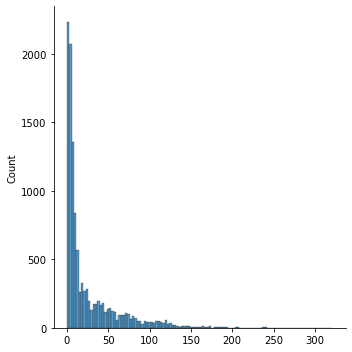

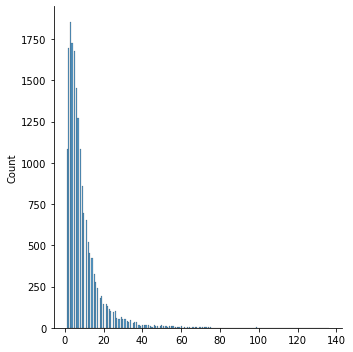

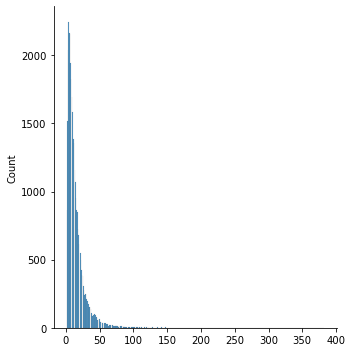

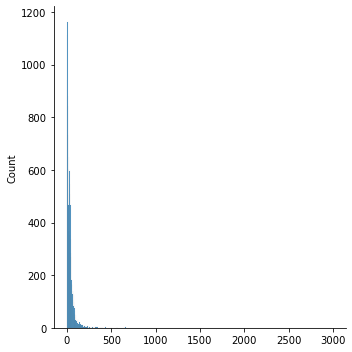

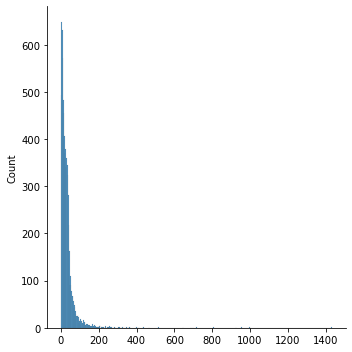

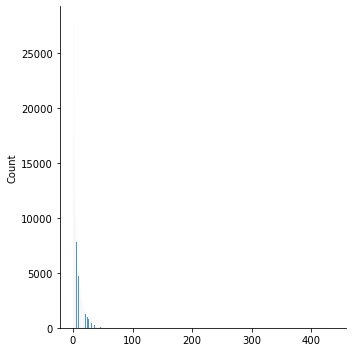

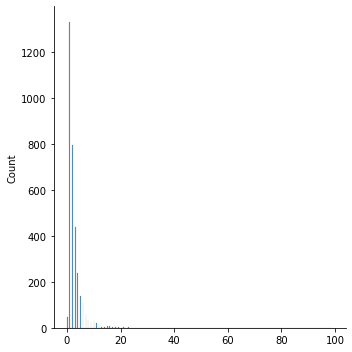

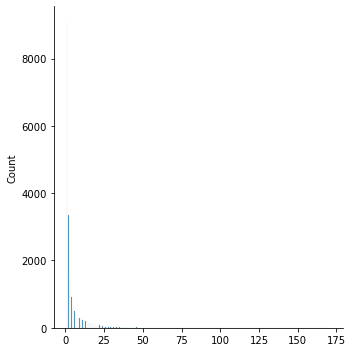

In [4]:
datasets = [wiki, cs, physics, computers, photo, arxiv, citeseer, pubmed]
for dataset in datasets:
    data = dataset[0]
    print(dataset)
    print("num_nodes", len(data.x), "num_edges", data.edge_index.size(1))
    print("num_features", dataset.num_features)
    print("num_classes", dataset.num_classes)
    print(f"Density {data.adj_t.density() * 100:.3f}%")
    out_degrees = data.adj_t.sum(dim=0)
    g = sns.displot(out_degrees)
    
    if not isinstance(dataset, PygNodePropPredDataset):
        try:
            train_size = data.train_mask[:, 0].sum(dim=0) / data.train_mask[:,0].numel()
            val_size = data.val_mask[:, 0].sum(dim=0) / data.val_mask[:,0].numel()
            train_distr = data.y[data.train_mask[:, 0]].unique(return_counts=True)[1]
        except IndexError:
            train_size = data.train_mask.sum(dim=0) / data.train_mask.numel()
            val_size = data.val_mask.sum(dim=0) / data.val_mask.numel()
            train_distr = data.y[data.train_mask].unique(return_counts=True)[1]
        test_size = data.test_mask.sum(dim=0) / data.test_mask.numel()
        test_distr = data.y[data.test_mask].unique(return_counts=True)[1]
    else:
        split = dataset.get_idx_split()
        train_idx, val_idx, test_idx = split["train"], split["valid"], split["test"]

        # wrapping .numel() in tensor for results of consistent type
        train_size = torch.tensor(train_idx.numel() / len(data.x))
        val_size = torch.tensor(val_idx.numel() / len(data.x))
        train_distr = data.y[train_idx].unique(return_counts=True)[1]
        test_size = torch.tensor(test_idx.numel() / len(data.x))
        test_distr = data.y[test_idx].unique(return_counts=True)[1]


    print(f"Fraction of nodes for a) training: {train_size.item()*100:.1f}%, "
          f"b) validation: {val_size.item()*100:.1f}%, c) testing: {test_size.item()*100:.1f}%")
    print(f"Class distribution of training set: {train_distr}")
    print(f"Class distribution of test set: {test_distr}")
    print(f"Minimal class id: {min(data.y)}")
    print(f"Minimal class prevalence in test set: {min(test_distr)}")
    print(data)
    print("-" * 32)

## Clustering Coefficient Distributions

In [5]:
g_citeseer = to_networkx(citeseer[0], to_undirected=True)
g_pubmed = to_networkx(pubmed[0], to_undirected=True)

In [6]:
for name, g in [("Citeseer", g_citeseer), ("Pubmed", g_pubmed)]:
    ccs = np.array([val for val in nx.clustering(g).values()])
    print(f"{name}: {(ccs == 0).sum() / len(ccs)} of nodes has a CC of zero.")


Citeseer: 0.6961226330027052 of nodes has a CC of zero.
Pubmed: 0.7556423390982401 of nodes has a CC of zero.
